# Training a Pizza Slice Angle Detector

**Runnable notebook: `pizza_walkthrough.ipynb`**

In [1]:
## Define imports

## Packages/environment contained in "requirements.yml"

## See 'dataloader.py' for custom dataloader class
from dataloader import create_data, PizzaDataset
## See 'model.py' for custom model class
from model import KeypointDetector
## See 'image_transforms.py' for custom image transforms
from image_transforms import *

## Some generic functions
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import v2


/home/sandippanesar/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/sandippanesar/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

## Load Data from SQL Database and Create Train-Test Split

The split function contains a seed method to randomly and deterministically split the data.

In [2]:
dl = create_data('./data/pizza_database.db','pizza_table')
train, valid = dl.split_data(0.8, ['index','data_path','x1','y1','x2','y2','other'])

## Define Image Transform Pipeline

Uses a combination of custom functions and those from the Torch library.

The rescale function also rescales the label coordinates.

NB: Due to time constraints, I decided to just normalize the image dimensions of each image. In some instances the aspect ratios are altered, which potentially causes a change in the angle of the pizza slice. 

To account for the change in angle that comes with the aspect ratios, once the predictions have been made by the trained model, the prediction coordinates are then transformed back to the coordinate space of the original image, which reflects the 'true' angle.

Inference can be run on the normalized data, and there is a function in the dataloader class ('transform_pred_to_normal') which rescales the keypoints back to the original height and width of the image before pre-processing.

In [3]:
transforms = v2.Compose([
    Rescale((224, 224)),
    Normalize(),
    v2.ToDtype(torch.float32),
])

## Transform Train Dataset

Create both transformed and untransformed datasets.

**Moving forward: x1,y1 is the tip and taken to be the origin point when calculating the angle relative to the vertical i.e. Y-axis**

The intention of both the data loader and the rest of this pipeline allows for **more training data to be added to the SQL database** so the model can be improved. 

Given more training data, batch size could be increased also. 

In [4]:
untransformed_train_dataset = PizzaDataset(train, './data/images')
transformed_train_dataset = PizzaDataset(train, './data/images', transforms)

print(f'Size of Training Dataset: {len(train)}')

train

Size of Training Dataset: 4


,index,data_path,x1,y1,x2,y2,other
0,676378,pizza0.jpg,65,905,108,875,None
1,603024,pizza1.jpg,99,243,99,224,None
2,893981,pizza3.jpg,1547,430,1466,420,None
3,162132,pizza4.jpg,270,409,325,399,None


## Visualize Examples

NB: Note Y-axis is flipped when interpreting printed angle. 

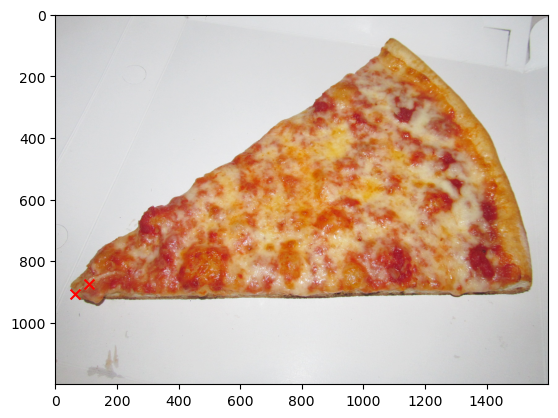

Angle of slice: 132.92996934695887


In [5]:
## Untransformed Image

eg0 = transformed_train_dataset.__getitem__(0)
eg0_u = untransformed_train_dataset.__getitem__(0)

dl.visualize_matrix_with_coordinates(eg0_u['image'], eg0_u['keypoints'], flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0['keypoints'])}")

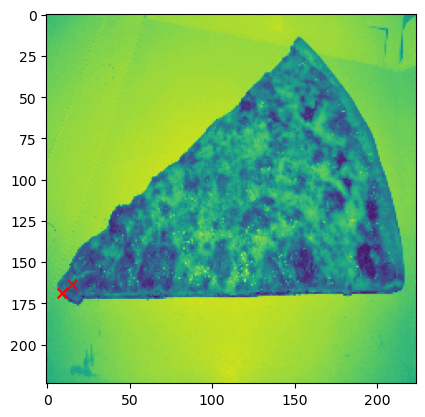

Angle of slice: 124.90249561592474


In [6]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg0['image'],eg0['keypoints'], flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0_u['keypoints'])}")

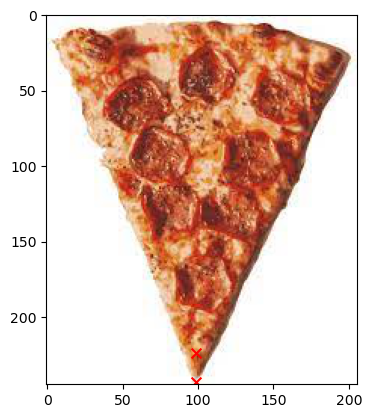

Angle of slice: 180.0


/home/sandippanesar/Desktop/pizza_angle_prediction/dataloader.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  m = (points[3] - points[2]) / (points[1] - points[0])


In [7]:
## Untransformed Image

eg1 = transformed_train_dataset.__getitem__(1)
eg1_u = untransformed_train_dataset.__getitem__(1)

dl.visualize_matrix_with_coordinates(eg1_u['image'],eg1_u['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1['keypoints'])}")

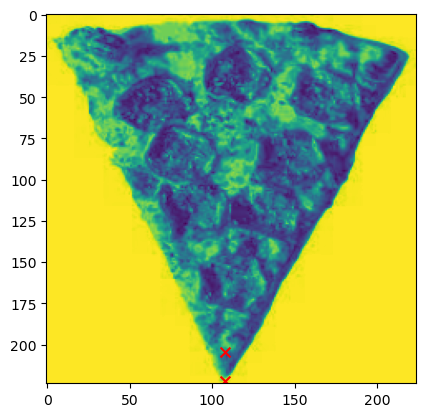

Angle of slice: 180.0


In [8]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg1['image'],eg1['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1_u['keypoints'])}")

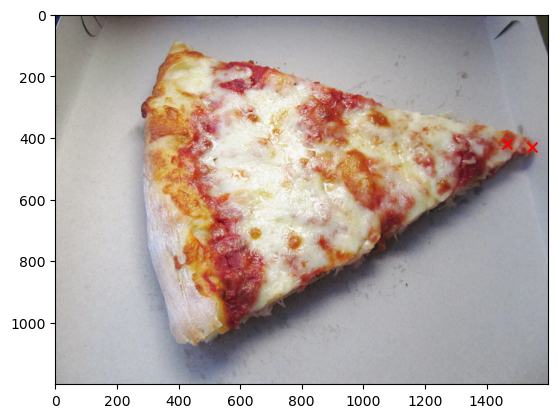

Angle of slice: 80.6524221903351


In [9]:
## Untransformed Image

eg2 = transformed_train_dataset.__getitem__(2)
eg2_u = untransformed_train_dataset.__getitem__(2)

dl.visualize_matrix_with_coordinates(eg2_u['image'],eg2_u['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

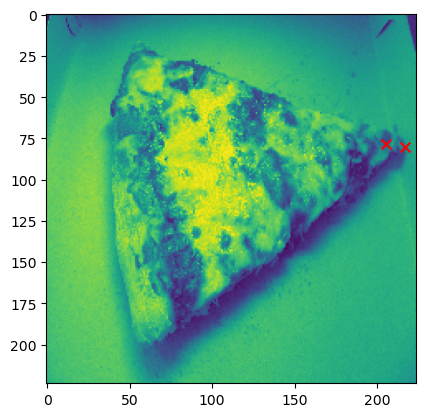

Angle of slice: 80.6524221903351


In [10]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg2['image'],eg2['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

## Create DataLoader Class For Datasets

In [11]:
train_loader = DataLoader(transformed_train_dataset, batch_size=1, shuffle=True)
untransformed_test_dataset = PizzaDataset(valid, './data/images')
transformed_test_dataset = PizzaDataset(valid, './data/images', transforms)
test_loader = DataLoader(transformed_test_dataset, batch_size=1, shuffle=True)

## Define Model Criteria For Training

L1Loss chosen specifically for keypoint detection task, over MSE or other loss functions. 

Has optional dropout layer.

Model 'KeypointDetector' contains: <br>
    - A convolutional layer <br>
    - A dropout layer <br>
    - A max pooling layer <br>
    - Another convolutional layer <br>
    - A dropout layer <br>
    - A fully connected layer <br>
    - Another fully connected layer which outputs an 1x4 array containing keypoint predictions [x1,x2,y1,y2]

Train model for 20 epochs. Might be overfit given size of training dataset. 

In [12]:
criterion = nn.L1Loss()
# device = 'cuda:0' ## If you have large enough GPU can uncomment this
device = 'cpu'
num_epochs = 20

## Define model with drouput
model = KeypointDetector(use_dropout=True)
model.to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Define model without dropout
model2 = KeypointDetector(use_dropout=False)
model2.to(device)
model2 = model2.double()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model w/o Dropout

Epoch [1/20], Loss: 84.4678
Epoch [2/20], Loss: 95.0840
Epoch [3/20], Loss: 65.2747
Epoch [4/20], Loss: 70.4862
Epoch [5/20], Loss: 43.1412
Epoch [6/20], Loss: 81.0602
Epoch [7/20], Loss: 62.0612
Epoch [8/20], Loss: 56.8554
Epoch [9/20], Loss: 66.5791
Epoch [10/20], Loss: 61.6216
Epoch [11/20], Loss: 54.3033
Epoch [12/20], Loss: 59.8105
Epoch [13/20], Loss: 58.7050
Epoch [14/20], Loss: 63.7697
Epoch [15/20], Loss: 60.3706
Epoch [16/20], Loss: 43.5193
Epoch [17/20], Loss: 51.8487
Epoch [18/20], Loss: 49.6787
Epoch [19/20], Loss: 50.4530
Epoch [20/20], Loss: 45.2872
Finished Training


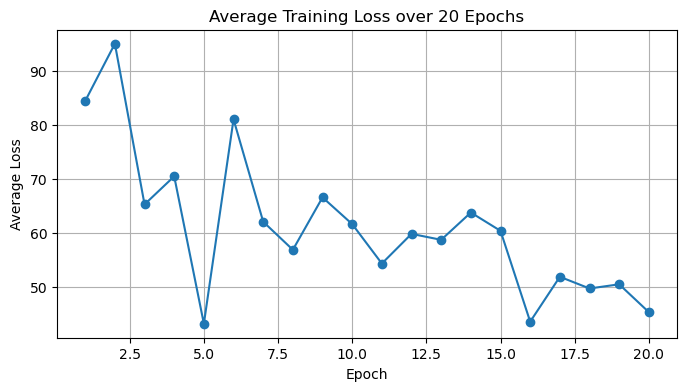

In [13]:
model.train_model(train_loader, criterion, optimizer, num_epochs, device)

## Train Model w/ Dropout

Epoch [1/20], Loss: 97.0534
Epoch [2/20], Loss: 55.9691
Epoch [3/20], Loss: 63.4243
Epoch [4/20], Loss: 58.8003
Epoch [5/20], Loss: 54.4927
Epoch [6/20], Loss: 66.8074
Epoch [7/20], Loss: 51.8898
Epoch [8/20], Loss: 72.6757
Epoch [9/20], Loss: 54.4850
Epoch [10/20], Loss: 52.1390
Epoch [11/20], Loss: 50.5206
Epoch [12/20], Loss: 60.1279
Epoch [13/20], Loss: 61.5077
Epoch [14/20], Loss: 47.3993
Epoch [15/20], Loss: 50.4702
Epoch [16/20], Loss: 47.2189
Epoch [17/20], Loss: 60.2534
Epoch [18/20], Loss: 53.8989
Epoch [19/20], Loss: 43.3720
Epoch [20/20], Loss: 47.8063
Finished Training


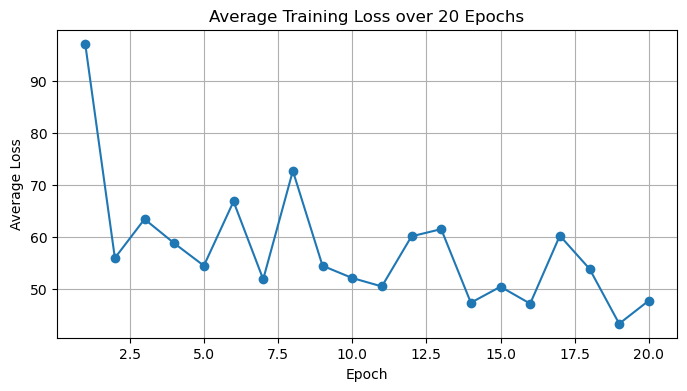

In [14]:
model2.train_model(train_loader, criterion, optimizer2, num_epochs, device)

## Run Evaluation on Validation Set

In [15]:
e1 = model.evaluate_model(model, test_loader, criterion, device)
e2 = model.evaluate_model(model2, test_loader, criterion, device)

print(f'Performance of first model on test dataset (average loss): {e1}')
print('-'*50)
print(f'Performance of second model on test dataset (average loss): {e2}')

Performance of first model on test dataset (average loss): 74.98613491133673
--------------------------------------------------
Performance of second model on test dataset (average loss): 103.807837380934


## Visualize the Predictions on Untransformed Validation Data

In [16]:
test_0 = transformed_test_dataset.__getitem__(0)
m1_preds = model.predict(model, test_0['image'])
m2_preds = model.predict(model2, test_0['image'])

m1_preds_rescaled = dl.transform_pred_to_normal(m1_preds, (224,224), untransformed_test_dataset.__getitem__(0)['image'])
m2_preds_rescaled = dl.transform_pred_to_normal(m2_preds, (224,224), untransformed_test_dataset.__getitem__(0)['image'])

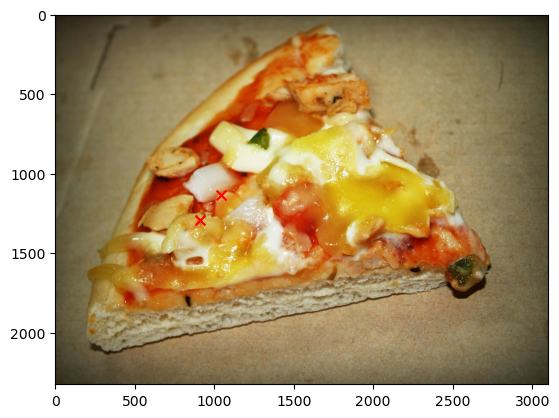

Angle of slice: 140.22932220776502


In [17]:
## Model 1

dl.visualize_matrix_with_coordinates(untransformed_test_dataset.__getitem__(0)['image'], m1_preds_rescaled, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m1_preds_rescaled)}")

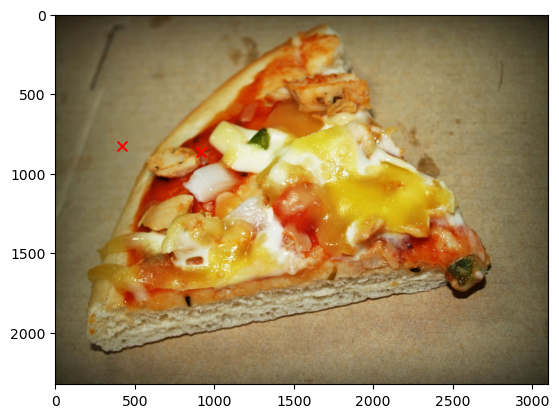

Angle of slice: 85.51200167739077


In [18]:
## Model 2

dl.visualize_matrix_with_coordinates(untransformed_test_dataset.__getitem__(0)['image'], m2_preds_rescaled, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m2_preds_rescaled)}")

## Conclusions

- Metrics wise, the model without dropout performs better.
- Despite a very limited training sample, a neural network with a keypoint prediction layer can be successfully trained.
- On the test dataset the predicted angle for the second image is somewhat correct, despite the keypoints not being correct. 

## Improvements

- Larger training set. 
- Potentially exploring different model architectures, pretrained models e.g. ResNet-50 etc. 